In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from  metal.utils import hard_to_soft
import torch

N = 1200
X = np.random.random((N,100)) * 2 - 1

Y = np.zeros((N,1))
Y[:,0] = (X[:,0] > X[:,1] + 0.5).astype(int) + 1

X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.long)

X_train = X[:1000]
X_dev   = X[1000:1100]
X_test  = X[1100:]

Y_train = Y[:1000, 0]
Y_dev   = Y[1000:1100]
Y_test  = Y[1100:, 0]

In [3]:
rs_max_search = 10

search_space = {
    'n_epochs': [10],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'print_every': 50
}

In [19]:
# First run basic grid search / random search
from metal.label_model import LabelModel
from metal.end_model import EndModel
from metal.tuners.random_tuner import RandomSearchModelTuner

def run_random_search(seed=123):
    tuner = RandomSearchModelTuner(EndModel, seed=seed)
    init_args = []
    train_args = [X_train, Y_train]
    model = tuner.search(init_args, train_args, X_dev, Y_dev, search_space,
                         max_search=rs_max_search, metric='f1',
                        verbose=False)
    return tuner.get_run_stats()

In [26]:

# Hyperband
from metal.label_model import LabelModel
from metal.end_model import EndModel
from metal.tuners.hyperband_tuner import HyperbandModelTuner

def run_hyperband(seed=123):    
    tuner = HyperbandModelTuner(EndModel, hyperband_epochs_budget=160, seed=seed)
    init_args = []
    train_args = [X_train, Y_train]

    model = tuner.search(init_args, train_args, X_dev, Y_dev, search_space, verbose=False)
    return tuner.get_run_stats()

In [27]:
#%%capture
seeds = [123, 234, 456, 567, 678]
#seeds = [123]
runstats_hyperband = []
runstats_rs = []
for seed in seeds:
    runstats_rs.append(run_random_search(seed=seed))
    runstats_hyperband.append(run_hyperband(seed=seed))
    
print(runstats_hyperband)
print(runstats_rs)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)



/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear

[[{'time_elapsed': 0.2056291103363037, 'best_score': 0.58}, {'time_elapsed': 0.7219891548156738, 'best_score': 0.64}, {'time_elapsed': 1.8372552394866943, 'best_score': 0.88}, {'time_elapsed': 5.623031139373779, 'best_score': 0.93}, {'time_elapsed': 7.3361289501190186, 'best_score': 0.95}], [{'time_elapsed': 0.22682595252990723, 'best_score': 0.87}, {'time_elapsed': 1.024226188659668, 'best_score': 0.88}, {'time_elapsed': 2.3594679832458496, 'best_score': 0.89}, {'time_elapsed': 2.9690990447998047, 'best_score': 0.91}, {'time_elapsed': 8.212209939956665, 'best_score': 0.92}], [{'time_elapsed': 0.2956109046936035, 'best_score': 0.75}, {'time_elapsed': 0.8180179595947266, 'best_score': 0.79}, {'time_elapsed': 3.0144760608673096, 'best_score': 0.88}, {'time_elapsed': 3.5532000064849854, 'best_score': 0.89}], [{'time_elapsed': 0.24532032012939453, 'best_score': 0.78}, {'time_elapsed': 0.4821791648864746, 'best_score': 0.79}, {'time_elapsed': 1.5008461475372314, 'best_score': 0.85}, {'time_

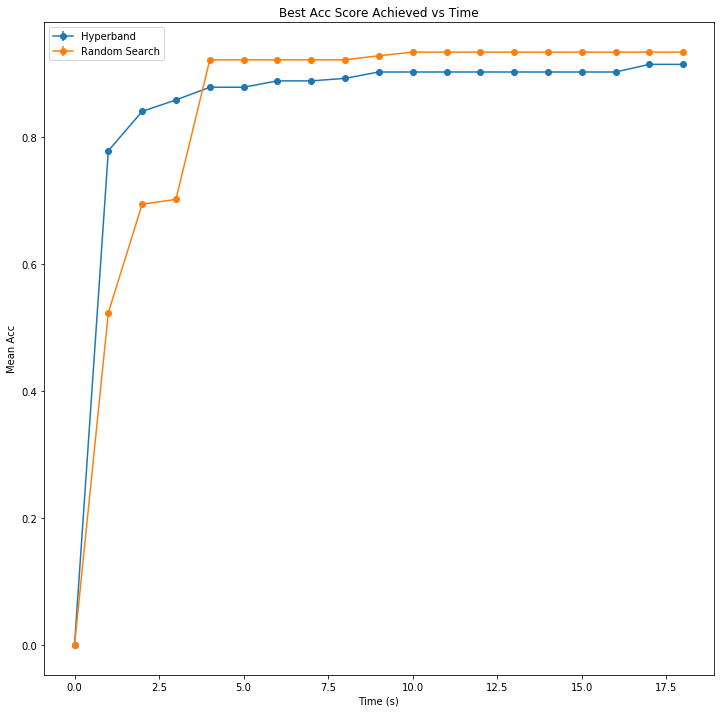

In [28]:
%matplotlib inline

# Plot random search vs hyperband run stats
import matplotlib.pyplot as plt
import matplotlib as mpl

print(runstats_hyperband)

xs_hyperband = [[x["time_elapsed"] for x in z] for z in runstats_hyperband]
ys_hyperband = [[x["best_score"] for x in z] for z in runstats_hyperband]
xs_rs = [[x["time_elapsed"] for x in z] for z in runstats_rs]
ys_rs = [[x["best_score"] for x in z] for z in runstats_rs]

# Extract min and max times for segmented times
flat_xs_hyperband = [item for sublist in xs_hyperband for item in sublist]
flat_xs_rs = [item for sublist in xs_rs for item in sublist]
min_time, max_time = 0, max(flat_xs_hyperband + flat_xs_rs)


# Get list of best scores at time
def get_best_scores_at_time(all_runstats, target_time):
    best_scores = []
    for runstats in all_runstats:
        best_score = 0        
        times = [x["time_elapsed"] for x in runstats]
        scores = [x["best_score"] for x in runstats]
        for time, score in zip(times, scores):
            if time < target_time:
                best_score = score
        best_scores.append(best_score)
    return best_scores
        
# Extract best scores per segment
segments = list(np.arange(0, max_time, 1))
hyperband_scores = [get_best_scores_at_time(runstats_hyperband, t) for t in segments]
rs_scores = [get_best_scores_at_time(runstats_rs, t) for t in segments]

# Extract means and error bars
mean_hyperband_scores = [np.mean(x) for x in hyperband_scores]
mean_rs_scores = [np.mean(x) for x in rs_scores]
#hyperband_stds = [np.std(x) for x in hyperband_scores]
#rs_stds = [np.std(x) for x in rs_scores]
hyperband_stds = [0 for x in hyperband_scores]
rs_stds = [0 for x in rs_scores]

#plt.plot(segments, mean_hyperband_scores, label="Hyperband", marker="o")
#plt.plot(segments, mean_rs_scores, label="Random Search", marker="o")
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.errorbar(segments, mean_hyperband_scores, hyperband_stds, label="Hyperband", marker="o")
plt.errorbar(segments, mean_rs_scores, rs_stds, label="Random Search", marker="o")
plt.legend(loc="best")
plt.title("Best Acc Score Achieved vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean Acc")

[[{'time_elapsed': 0.2056291103363037, 'best_score': 0.58}, {'time_elapsed': 0.7219891548156738, 'best_score': 0.64}, {'time_elapsed': 1.8372552394866943, 'best_score': 0.88}, {'time_elapsed': 5.623031139373779, 'best_score': 0.93}, {'time_elapsed': 7.3361289501190186, 'best_score': 0.95}], [{'time_elapsed': 0.22682595252990723, 'best_score': 0.87}, {'time_elapsed': 1.024226188659668, 'best_score': 0.88}, {'time_elapsed': 2.3594679832458496, 'best_score': 0.89}, {'time_elapsed': 2.9690990447998047, 'best_score': 0.91}, {'time_elapsed': 8.212209939956665, 'best_score': 0.92}], [{'time_elapsed': 0.2956109046936035, 'best_score': 0.75}, {'time_elapsed': 0.8180179595947266, 'best_score': 0.79}, {'time_elapsed': 3.0144760608673096, 'best_score': 0.88}, {'time_elapsed': 3.5532000064849854, 'best_score': 0.89}], [{'time_elapsed': 0.24532032012939453, 'best_score': 0.78}, {'time_elapsed': 0.4821791648864746, 'best_score': 0.79}, {'time_elapsed': 1.5008461475372314, 'best_score': 0.85}, {'time_

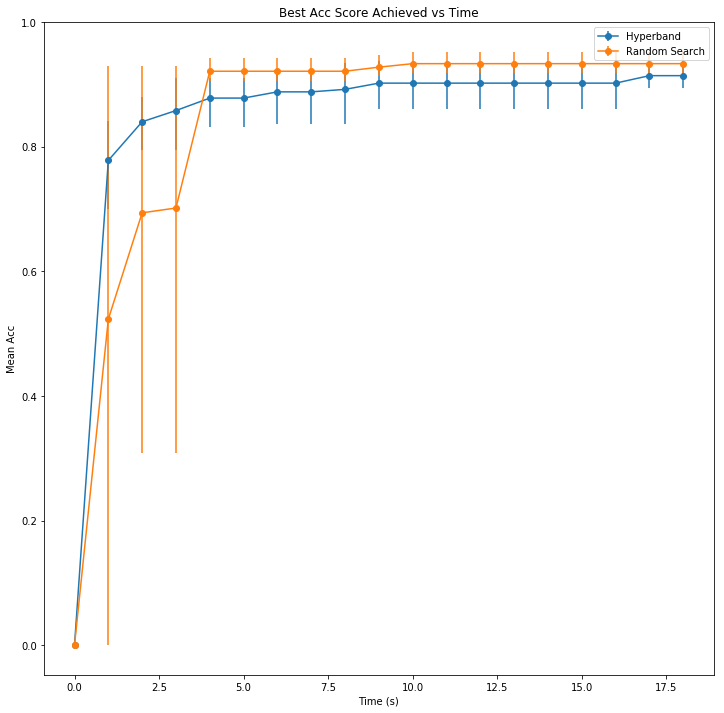

In [29]:
%matplotlib inline

# Plot random search vs hyperband run stats
import matplotlib.pyplot as plt
import matplotlib as mpl

print(runstats_hyperband)

xs_hyperband = [[x["time_elapsed"] for x in z] for z in runstats_hyperband]
ys_hyperband = [[x["best_score"] for x in z] for z in runstats_hyperband]
xs_rs = [[x["time_elapsed"] for x in z] for z in runstats_rs]
ys_rs = [[x["best_score"] for x in z] for z in runstats_rs]

# Extract min and max times for segmented times
flat_xs_hyperband = [item for sublist in xs_hyperband for item in sublist]
flat_xs_rs = [item for sublist in xs_rs for item in sublist]
min_time, max_time = 0, max(flat_xs_hyperband + flat_xs_rs)


# Get list of best scores at time
def get_best_scores_at_time(all_runstats, target_time):
    best_scores = []
    for runstats in all_runstats:
        best_score = 0        
        times = [x["time_elapsed"] for x in runstats]
        scores = [x["best_score"] for x in runstats]
        for time, score in zip(times, scores):
            if time < target_time:
                best_score = score
        best_scores.append(best_score)
    return best_scores
        
# Extract best scores per segment
segments = list(np.arange(0, max_time, 1))
hyperband_scores = [get_best_scores_at_time(runstats_hyperband, t) for t in segments]
rs_scores = [get_best_scores_at_time(runstats_rs, t) for t in segments]

# Extract means and error bars
mean_hyperband_scores = [np.mean(x) for x in hyperband_scores]
mean_rs_scores = [np.mean(x) for x in rs_scores]
hyperband_stds = [[-np.percentile(x, 10)+np.mean(x) for x in hyperband_scores], [np.percentile(x, 90)-np.mean(x) for x in hyperband_scores]]
rs_stds = [[-np.percentile(x, 10)+np.mean(x) for x in rs_scores], [np.percentile(x, 90)-np.mean(x) for x in rs_scores]]


#plt.plot(segments, mean_hyperband_scores, label="Hyperband", marker="o")
#plt.plot(segments, mean_rs_scores, label="Random Search", marker="o")
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.errorbar(segments, mean_hyperband_scores, hyperband_stds, label="Hyperband", marker="o")
plt.errorbar(segments, mean_rs_scores, rs_stds, label="Random Search", marker="o")
plt.legend(loc="best")
plt.title("Best Acc Score Achieved vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean Acc")